# Aula 2.3 - Informações faltantes

## MBA em Ciência de Dados
## Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Tratamento e limpeza de bases de dados</span>


## <span style="color:darkred">Informações faltantes</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

## Informações faltantes

Problemas com dados do tipo: faltantes (e errôneos, os quais também ocasionam perdas) podem levar a impactos nos modelos estatísticos e de aprendizado.

A primeira etapa é **detectar corretamente** as informações faltantes, estudar os atributos onde ocorrem, separando em:
* Dados faltantes: no Python `NaN`, sendo indefinidos ou não encontrados
* Dados errôneos: valores que devem ser removidos para não prejudicar a análise. Comumente não são *outliers* mas dados corrompidos no armazenamento, transmissão ou inputação.

A seguir, temos como opções
1. Remover as linhas/instâncias contendo valores faltantes
2. Preencher valores faltantes utilizando algum método

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("./dados/houses_to_rent_mba2.csv")
data

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
0,São Paulo,70.0,2.0,1,1.0,7,2065,3300,211,42,5618.0,324,23,108,3,flat
1,São Paulo,320.0,4.0,4,2.0,20,1200,4960,1750,63,7973.0,720,78,240,11,flat
2,Porto Alegre,80.0,1.0,1,1.0,6,1000,2800,nr,41,3841.0,64,269,128,38,flat
3,Porto Alegre,51.0,1.0,1,NaN,2,270,1112,22,17,1421.0,46,73,92,10,flat
4,São Paulo,25.0,1.0,1,NaN,1,0,800,25,11,836.0,1548,78,516,11,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,São Paulo,150.0,3.0,3,2.0,8,0,13500,0,172,13672.0,2124,114,708,16,flat
11761,Porto Alegre,63.0,2.0,1,1.0,5,402,1478,24,22,1926.0,58,86,116,12,flat
11762,São Paulo,285.0,4.0,4,4.0,17,3100,15000,973,191,19264.0,612,99,204,14,flat
11763,Brotas,100.0,1.0,2,1.0,-,0,800,116,39,955.0,148,127,148,18,house



### Experimento com tratamento de dados

Vamos utilizar essa base de dados como meio de estudo, com duas tarefas:
1. classificador para predizer a **cidade** com base nos atributos: imposto, valor total e valor do seguro
2. regressor para predizer o **total** do aluguel com base nos atributos: área, número de quartos, andar, tipo, número de vagas na garagem e número de banheiros.

Repassaremos conceitos como **remoção de duplicatas e de outliers**


1. Separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [2]:
# obtem amostra dos dados para treinamento
frac_trein = 0.3
dtrain = data.sample(frac=frac_trein, random_state=1) # amostra trein.
dtest = data.drop(dtrain.index) # amostra teste

print(len(dtrain) + len(dtest))

11765


Vamos tentar obter um **classificador** sem realizar nenhum tratamento na base de dados

In [4]:
# preparando os atributos
Xcla = dtrain[['tax','total','insurance']]
Ycla = dtrain['city']

# dados de teste
ZXcla = dtest[['tax','total','insurance']]
ZYcla = dtest['city']

# classificador
clfb = RandomForestClassifier(n_estimators=50, random_state=1)
clfb.fit(Xcla,Ycla)
ZYcla_ = clfb.predict(ZXcla)

ValueError: could not convert string to float: '-'

**Encontramos o primeiro erro! Vamos olhar para os atributos antes de treinar...**
Note que o erro é de conversão de string para float. Vamos imprimir os tipos dos atributos e seus valores únicos:

In [5]:
data.dtypes

city                object
area               float64
rooms              float64
bathroom             int64
parking spaces     float64
floor               object
hoa                  int64
rent                 int64
tax                 object
insurance            int64
total              float64
page hits            int64
days available       int64
interactions         int64
weeks available      int64
type                object
dtype: object

In [6]:
for var in dtrain:
    print(40*'-')
    print(var,':', dtrain[var].dtype.name)
    if dtrain[var].dtype.name == 'object':
        print(dtrain.groupby(var, dropna=False, as_index=False).size())
    else:
        print(dtrain[var].describe())
        print('Total de faltantes: ', np.sum(dtrain[var].isna()),'\n')

----------------------------------------
city : object
             city  size
0  Belo Horizonte   368
1          Brotas     3
2        Campinas   244
3    Porto Alegre   332
4  Rio de Janeiro   440
5       São Paulo  2143
----------------------------------------
area : float64
count     3509.000000
mean       146.410373
std        433.867590
min         12.000000
25%         56.000000
50%         91.000000
75%        181.000000
max      24606.000000
Name: area, dtype: float64
Total de faltantes:  21 

----------------------------------------
rooms : float64
count    3503.000000
mean        2.477591
std         1.150322
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: rooms, dtype: float64
Total de faltantes:  27 

----------------------------------------
bathroom : int64
count    3530.000000
mean        2.274504
std         1.444447
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max     

Note que:
* `city` e `type` são do tipo object contendo strings (palavras), 
* `floor` e `tax` aparecem como object mas contendo números!

Precisamos procurar por problemas e remover os valores não numéricos como `-`. 

Uma forma fácil é simplesmente forçar a **conversão para numérico** e atribuir `NaN` aos elementos não convertidos.

1. `floor` possui um único valor não numérico `-`:

['7' '5' '3' '11' '-' '2' '15' '6' '1' '20' '4' '17' '21' '8' '13' '9'
 '18' '12' '10' '19' '14' '23' '22' '26' '25' '16' '27' '110' '24' '28']


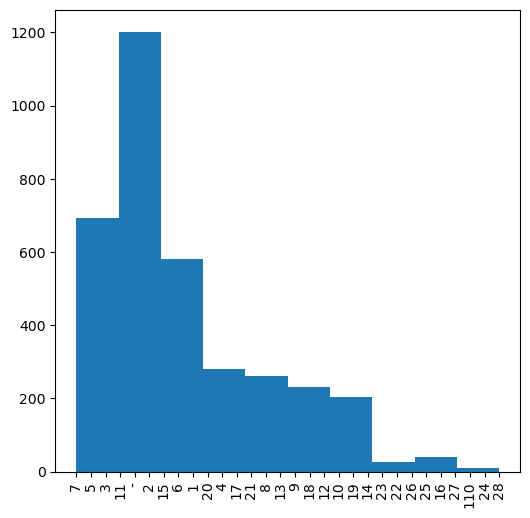

In [7]:
plt.figure(figsize=(6,6))
h = plt.hist(dtrain.loc[:,'floor'])
h = plt.xticks(rotation=90)
print(dtrain.loc[:,'floor'].unique())

Esse valor parece estar relacionado ao `0` (térreo)

In [8]:
dtrain_orig = dtrain.copy()

# substituir `-` por `0`
dtrain.loc[dtrain['floor']=='-','floor'] = '0'

# coerce obriga a conversão, jogando para NaN o que não foi convertido
dtrain['floor'] = pd.to_numeric(dtrain['floor'], downcast='integer', errors='coerce')
#dtrain.loc[:,'floor'] = pd.to_numeric(dtrain.loc[:,'floor'], downcast='integer', errors='coerce')

# tax será convertido diretamente, sem substituicao de valores
dtrain['tax'] = pd.to_numeric(dtrain['tax'], downcast='float', errors='coerce')
#dtrain.loc[:,'tax'] = pd.to_numeric(dtrain.loc[:,'tax'], downcast='float', errors='coerce')

In [9]:
# vamos fazer o mesmo com o teste
dtest.loc[dtest['floor']=='-','floor'] = '0'
#dtest.loc[:,'floor'] = pd.to_numeric(dtest.loc[:,'floor'], downcast='integer', errors='coerce')
#dtest.loc[:,'tax'] = pd.to_numeric(dtest.loc[:,'tax'], downcast='float', errors='coerce')

dtest['floor'] = pd.to_numeric(dtest['floor'], downcast='integer', errors='coerce')
dtest['tax'] = pd.to_numeric(dtest['tax'], downcast='float', errors='coerce')

Após tratar os casos de conversão, podemos **remover os faltantes**

In [10]:
print("Treinamento antes: %d" % (dtrain.shape[0]))
print("Teste antes: %d" % (dtest.shape[0]))

Treinamento antes: 3530
Teste antes: 8235


In [11]:
dtrain = dtrain.dropna()
dtest = dtest.dropna()

In [12]:
print("Treinamento após remoção faltantes: %d" % (dtrain.shape[0]))
print("Teste após remoção faltantes: %d" % (dtest.shape[0]))

Treinamento após remoção faltantes: 2626
Teste após remoção faltantes: 6035


In [13]:
for var in dtrain:
    # imprime variavel e seu tipo
    print(var,":", dtrain[var].dtype.name, end="")
    # se nao numérico
    if not np.issubdtype(dtrain[var].dtype, np.number):
        print("\n\t",dtrain[var].nunique(), "distintos: ", end="")
        print(dtrain[var].unique())
    else:
        print(", intervalo: ",end="")
        print(dtrain[var].min(), ",", dtrain[var].max())
        
print("Antes: %d, Depois: %d" % (dtrain_orig.shape[0], dtrain.shape[0]))

city : object
	 6 distintos: ['Rio de Janeiro' 'São Paulo' 'Belo Horizonte' 'Porto Alegre' 'Campinas'
 'Brotas']
area : float64, intervalo: 20.0 , 24606.0
rooms : float64, intervalo: 1.0 , 10.0
bathroom : int64, intervalo: 1 , 20
parking spaces : float64, intervalo: 1.0 , 8.0
floor : int8, intervalo: 0 , 110
hoa : int64, intervalo: 0 , 14000
rent : int64, intervalo: 500 , 30000
tax : float32, intervalo: 0.0 , 28120.0
insurance : int64, intervalo: 5 , 451
total : float64, intervalo: 559.0 , 32183.0
page hits : int64, intervalo: 0 , 6156
days available : int64, intervalo: 0 , 358
interactions : int64, intervalo: 0 , 2052
weeks available : int64, intervalo: 0 , 51
type : object
	 2 distintos: ['flat' 'house']
Antes: 3530, Depois: 2626


###  Tratando duplicatas

In [14]:
dtrain_nd = dtrain.drop_duplicates(keep='first')
print("Antes: %d, Depois: %d" % (dtrain.shape[0], dtrain_nd.shape[0]))

Antes: 2626, Depois: 2454


In [15]:
# preparando os atributos
attrsclass = ['tax','total','insurance','rooms', 'bathroom', 'area']
Xcla = dtrain[attrsclass]
Ycla = dtrain['city']

# dados de teste
ZXcla = dtest[attrsclass]
ZYcla = dtest['city']

# classificador
clfb = RandomForestClassifier(n_estimators=50, random_state=1)
clfb.fit(Xcla,Ycla)
ZYcla_ = clfb.predict(ZXcla)

# dados sem duplicatas
Xcla_nd = dtrain_nd[attrsclass]
Ycla_nd = dtrain_nd['city']

# classificador dados não duplicados
clfnd = RandomForestClassifier(n_estimators=50, random_state=1)
clfnd.fit(Xcla_nd,Ycla_nd)
ZYcland_ = clfnd.predict(ZXcla)

print("Original: %d, Tratado: %d" % (Xcla.shape[0], Xcla_nd.shape[0]))

Original: 2626, Tratado: 2454


É importante verificar como é a **distribuição das classes** nessa base de dados para utilizar a medida adequada de avaliação

In [16]:
dtrain['city'].value_counts()

city
São Paulo         1652
Belo Horizonte     318
Rio de Janeiro     245
Porto Alegre       216
Campinas           192
Brotas               3
Name: count, dtype: int64

Como nesse caso as classes não são igualmente distribuídas, vamos computar, além da acurácia simples, também a *acurácia balanceada*

In [17]:
acc_base = metrics.accuracy_score(ZYcla, ZYcla_)
acc_nd = metrics.accuracy_score(ZYcla, ZYcland_)
print("Acurácia base: %0.2f" % (acc_base*100))
print("- sem duplicatas e com dados faltantes removidos: %0.2f" % (acc_nd*100))

ab_base = metrics.balanced_accuracy_score(ZYcla, ZYcla_)
ab_nd = metrics.balanced_accuracy_score(ZYcla, ZYcland_)
print("\nAcurácia balanceada base: %0.2f" % (ab_base*100))
print("- sem duplicatas e com dados faltantes removidos: %0.2f" % (ab_nd*100))

Acurácia base: 70.14
- sem duplicatas e com dados faltantes removidos: 69.66

Acurácia balanceada base: 40.65
- sem duplicatas e com dados faltantes removidos: 40.63


In [18]:
# Treinando regressor
## preparando atributos de entrada
attrsreg = ['area','rooms','bathroom', 'floor'];
Xreg = dtrain[attrsreg]
## variável resposta/saída
Yreg = dtrain['total']

## preparando teste
ZXreg = dtest[attrsreg]
ZYreg = dtest['total']

## dados sem duplicatas
Xreg_nd = dtrain_nd[attrsreg]
Yreg_nd = dtrain_nd['total']

In [19]:
regb = LinearRegression()
regb.fit(Xreg, Yreg)
ZYreg_ = regb.predict(ZXreg)

reg_nd = LinearRegression()
reg_nd.fit(Xreg_nd, Yreg_nd)
ZYreg_nd_ = reg_nd.predict(ZXreg)

mae_base = metrics.mean_absolute_error(ZYreg, ZYreg_)
mae_nd = metrics.mean_absolute_error(ZYreg, ZYreg_nd_)
print("Erro médio absoluto: %0.3f" % (mae_base))
print("Erro médio absoluto após limpeza: %0.3f" % (mae_nd))

Erro médio absoluto: 2638.399
Erro médio absoluto após limpeza: 2635.644


Percorrendo atributos de interesse para remover outliers

In [20]:
def remove_outliers_IQR(df, attributes, factor=2):
    
    dfn = df.copy()
    
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = dfn[var].quantile(0.25)
            Q2 = dfn[var].quantile(0.50)
            Q3 = dfn[var].quantile(0.75)
            IQR = Q3 - Q1
            
            # apenas inliers segundo IQR
            dfn = dfn.loc[(df[var] >= Q1-(IQR*factor)) & (df[var] <= Q3+(IQR*factor)),:]

    return dfn

attributes = ['tax','total','insurance', 'area', 'rooms', 'bathroom']
dtrain_out = remove_outliers_IQR(dtrain_nd, attributes)
dtest_out = remove_outliers_IQR(dtest, attributes)

print("Antes: %d, Depois: %d" % (dtrain_nd.shape[0], dtrain_out.shape[0]))

Antes: 2454, Depois: 2167


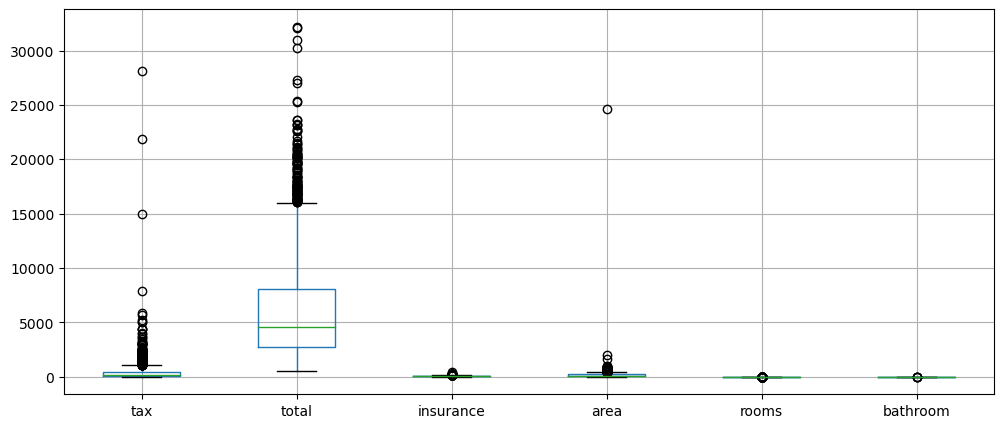

In [21]:
plt.figure(figsize=(12,5))
dtrain.boxplot(attributes);

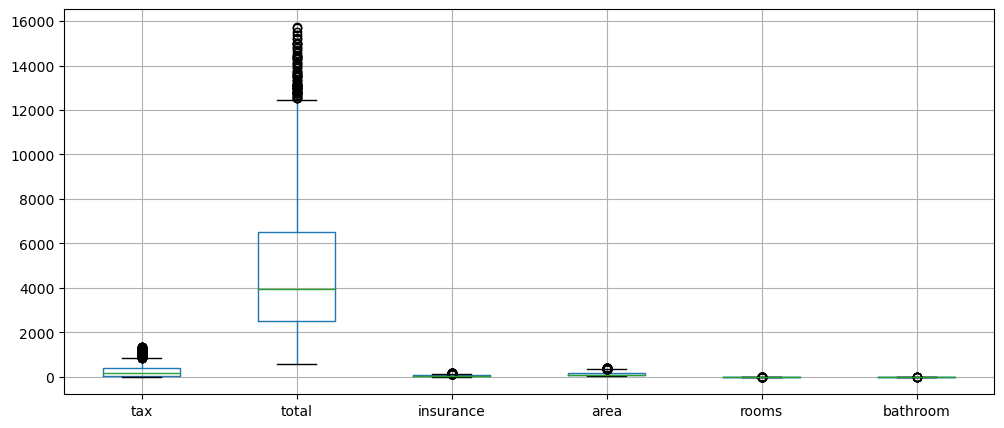

In [22]:
plt.figure(figsize=(12,5))
dtrain_out.boxplot(attributes);

In [23]:
# Treinando classificador com dados após remoção de outliers
Xclao = dtrain_out[attrsclass]
Yclao = dtrain_out['city']
ZXclao = dtest_out[attrsclass]
ZYclao = dtest_out['city']

clfo = RandomForestClassifier(n_estimators=50, random_state=1)
clfo.fit(Xclao,Yclao)
ZYcla_o_ = clfo.predict(ZXcla)

In [24]:
ab_o = metrics.balanced_accuracy_score(ZYcla, ZYcla_o_)
print("\nAcurácia balanceada base: %0.2f" % (ab_base*100))
print("- sem duplicatas e com dados faltantes removidos: %0.2f" % (ab_nd*100))
print("- tratando outliers: %0.2f" % (ab_o*100))


Acurácia balanceada base: 40.65
- sem duplicatas e com dados faltantes removidos: 40.63
- tratando outliers: 40.41


In [25]:
# avaliando regressor
Xreg_o = dtrain_out[attrsreg]
Yreg_o = dtrain_out['total']

reg_o = LinearRegression()
reg_o.fit(Xreg_o, Yreg_o)
ZYreg_o_ = reg_o.predict(ZXreg)

mae_o = metrics.mean_absolute_error(ZYreg, ZYreg_o_)
print("Erro médio absoluto: %0.2f" % (mae_base))
print("Erro médio absoluto limpeza: %0.2f" % (mae_nd))
print("Erro médio absoluto tratando outliers: %0.2f" % (mae_o))

Erro médio absoluto: 2638.40
Erro médio absoluto limpeza: 2635.64
Erro médio absoluto tratando outliers: 2378.14


#  Preenchendo dados faltantes

No experimento anterior lidamos com dados faltantes **removendo linhas**, 

Agora vamos carregar novamente os dados e para **preencher os dados**, mantendo o tratamento de remoção de duplicatas, dos atributos string e de remoção de outliers

Há várias formas de se preencher dados faltantes
1. **com zeros ou valor constante**: 
    para manter a instância e permitir o uso dos outros atributos
<br>    

2. **pela média**: similar ao anterior, mas aqui preenchemos com a média do atributo para os valores observados
<br>    

3. **por vizinhos mais próximos**: refinamento do método da média, no qual, para cada valor faltante, primeiro encontramos as $k$ instâncias mais próximas àquela contendo o valor faltante e obtemos a média do atributo a partir dos $k$ vizinhos mais próximos
<br>    

4. **por regressão**: para cada atributo faltante, aprendemos um regressor capaz de predizer o atributo faltante com base em um ou mais atributos auxiliares

In [26]:
data = pd.read_csv("./dados/houses_to_rent_mba2.csv")

# obtem amostra dos dados para treinamento
dtrain = data.sample(frac=frac_trein, random_state=1)
dtest = data.drop(dtrain.index)

dtrain_orig = dtrain.copy()

# substituir - por 0
dtrain.loc[dtrain['floor']=='-','floor'] = '0'
# coerce obriga a conversão, jogando para Nan que não foi convertido
#dtrain.loc[:,'floor'] = pd.to_numeric(dtrain.loc[:,'floor'], downcast='integer', errors='coerce')
#dtrain.loc[:,'tax'] = pd.to_numeric(dtrain.loc[:,'tax'], downcast='float', errors='coerce')
dtrain['floor'] = pd.to_numeric(dtrain['floor'], downcast='integer', errors='coerce')
dtrain['tax'] = pd.to_numeric(dtrain['tax'], downcast='float', errors='coerce')

dtest.loc[dtest['floor']=='-','floor'] = '0'
#dtest.loc[:,'floor'] = pd.to_numeric(dtest.loc[:,'floor'], downcast='integer', errors='coerce')
#dtest.loc[:,'tax'] = pd.to_numeric(dtest.loc[:,'tax'], downcast='float', errors='coerce')
dtest['floor'] = pd.to_numeric(dtest['floor'], downcast='integer', errors='coerce')
dtest['tax'] = pd.to_numeric(dtest['tax'], downcast='float', errors='coerce')

# remove duplicatas
dtrain_nd = dtrain.drop_duplicates(keep='first')
print("Dados originais: %d, após remocao duplicatas: %d" % (dtrain.shape[0], dtrain_nd.shape[0]))

# remove outliers
attributes = ['tax','total','insurance', 'bathroom']
dtrain_out = remove_outliers_IQR(dtrain_nd, attributes)
dtest_out = remove_outliers_IQR(dtest, attributes)

print("Após remocao outliers: %d" % (dtrain_out.shape[0]))

Dados originais: 3530, após remocao duplicatas: 3285
Após remocao outliers: 2892


In [27]:
def check_missing_att(df):
    # verificando atributos faltantes
    for var in df:
        # somamos o número de variáveis nulas (NaN)
        nullatt = np.sum(df[var].isnull())
        if nullatt > 0:
            print(var,"- faltantes: ", end='')
            print(nullatt)

In [28]:
check_missing_att(dtrain_out)

area - faltantes: 18
rooms - faltantes: 22
parking spaces - faltantes: 761


### Preenchimento com valor constante

In [29]:
dtrain_out_fill0 = dtrain_out.fillna(0)

In [30]:
check_missing_att(dtrain_out_fill0)

### Preenchimento pela média

In [31]:
def fill_missing_average(df):
        
    dfn = df.copy()
    for i in dfn:
        nullatt = np.sum(dfn[i].isnull())
        if nullatt == 0: continue
        print(i, nullatt, 'faltantes')
        
        # obtem a media para os dados completos no atributo
        # dfn[i].notnull() -> elementos completos no atributo i
        # dfn.loc[dfn[i].notnull(),i] -> filtra os valores completos do atributo i
        avg_compl = dfn.loc[dfn[i].notnull(),i].mean().astype(dfn[i].dtype)
        print('\tmédia =', avg_compl)
        dfn.loc[dfn[i].isnull(),i] = avg_compl
        
    return dfn

In [32]:
dtrain_mism = fill_missing_average(dtrain_out)

check_missing_att(dtrain_mism)
dtrain_mism.tail()

area 18 faltantes
	média = 112.30967292971468
rooms 22 faltantes
	média = 2.3142857142857145
parking spaces 761 faltantes
	média = 1.8259033317691225


,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
9572,São Paulo,80.0,3.0,1,1.825903,0,0,2837,342.0,36,3215.0,540,91,180,13,house
925,São Paulo,90.0,3.0,2,2.000000,5,1478,2500,355.0,32,4365.0,612,49,204,7,flat
4476,Belo Horizonte,80.0,1.0,2,1.825903,2,150,1100,68.0,15,1333.0,54,70,54,10,flat
3592,São Paulo,180.0,3.0,4,3.000000,3,1600,3500,65.0,45,5210.0,396,36,132,5,flat
10548,Belo Horizonte,26.0,1.0,1,1.000000,1,60,750,67.0,10,887.0,108,45,108,6,flat


In [33]:
def fill_missing_regression(df, attributes, attributes_reg):
    """ Funcao para preencher dados faltantes por regressao
        parametros:
            df - dataframe
            attributes - lista de atributos a preencher (alvo/saida)
            attributes_reg - lista dos respectivos atributos a serem usados na regressao
                             como variaveis de entrada
    """
    
    dfn = df.copy()
    print(len(attributes), ' attributos: ')
    for i in range(len(attributes)):
        print('-', i, ': preencher ', attributes[i], ' usando ', attributes_reg[i], end=' -- ')
        nullatt = np.sum(dfn[attributes[i]].isnull())
        print(nullatt, ' faltantes')
        if nullatt == 0: continue
        
        # atributo de entrada para dados completos
        Xa = np.array(dfn.loc[dfn[attributes[i]].notnull() & dfn[attributes_reg[i]].notnull(), 
                              attributes_reg[i]])
        # atributo de saida para dados completos
        Ya = np.array(dfn.loc[dfn[attributes[i]].notnull() & dfn[attributes_reg[i]].notnull(), 
                              attributes[i]])
        
        reg = LinearRegression()
        reg.fit(Xa.reshape(-1, 1), Ya.reshape(-1, 1))
        
        # seleciona as variáveis de entrada 
        # relativa aos valores faltantes para fazer a regressao
        Zr = dfn.loc[ dfn[attributes[i]].isnull(), attributes_reg[i]]
        
        # prediz as variaveis faltantes
        Za = reg.predict( (np.array(Zr)).reshape(-1, 1) )

        # monta array para substituir a variavel agora preenchida
        att_fill = np.array(dfn.loc[:, attributes[i]])
        att_fill[np.where(np.isnan(att_fill))] = np.array(Za.flatten()).astype(int)
        #dfn.loc[:,attributes[i]] = att_fill.astype(np.int32)
        dfn[attributes[i]] = att_fill.astype(np.int32)

        #print(dfn.loc[df[attributes[i]].isnull(), attributes[i]])
        
    return dfn

In [34]:
attributes     = ['rooms', 'parking spaces', 'area', 'tax']
attributes_reg = ['area', 'rent', 'tax', 'hoa']

dtrain_misr = fill_missing_regression(dtrain_out, attributes, attributes_reg)

check_missing_att(dtrain_misr)

4  attributos: 
- 0 : preencher  rooms  usando  area -- 22  faltantes
- 1 : preencher  parking spaces  usando  rent -- 761  faltantes
- 2 : preencher  area  usando  tax -- 18  faltantes
- 3 : preencher  tax  usando  hoa -- 0  faltantes


In [35]:
dtrain_out.tail()

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
9572,São Paulo,80.0,3.0,1,NaN,0,0,2837,342.0,36,3215.0,540,91,180,13,house
925,São Paulo,90.0,3.0,2,2.0,5,1478,2500,355.0,32,4365.0,612,49,204,7,flat
4476,Belo Horizonte,80.0,1.0,2,NaN,2,150,1100,68.0,15,1333.0,54,70,54,10,flat
3592,São Paulo,180.0,3.0,4,3.0,3,1600,3500,65.0,45,5210.0,396,36,132,5,flat
10548,Belo Horizonte,26.0,1.0,1,1.0,1,60,750,67.0,10,887.0,108,45,108,6,flat


In [36]:
dtrain_misr.tail()

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,page hits,days available,interactions,weeks available,type
9572,São Paulo,80,3,1,1,0,0,2837,342.0,36,3215.0,540,91,180,13,house
925,São Paulo,90,3,2,2,5,1478,2500,355.0,32,4365.0,612,49,204,7,flat
4476,Belo Horizonte,80,1,2,1,2,150,1100,68.0,15,1333.0,54,70,54,10,flat
3592,São Paulo,180,3,4,3,3,1600,3500,65.0,45,5210.0,396,36,132,5,flat
10548,Belo Horizonte,26,1,1,1,1,60,750,67.0,10,887.0,108,45,108,6,flat


In [37]:
# Treinando classificador preenchimento media
Xclamism = dtrain_mism[attrsclass]
Yclamism = dtrain_mism['city']

clfmm =  RandomForestClassifier(n_estimators=50, random_state=1)
clfmm.fit(Xclamism,Yclamism)
ZYcla_mm_ = clfmm.predict(ZXcla)

# Treinando classificador prenchimento pelo regressor
Xclamisr = dtrain_misr[attrsclass]
Yclamisr = dtrain_misr['city']

clfmr =  RandomForestClassifier(n_estimators=50, random_state=1)
clfmr.fit(Xclamisr,Yclamisr)
ZYcla_mr_ = clfmr.predict(ZXcla)

In [38]:
ab_mm = metrics.balanced_accuracy_score(ZYcla, ZYcla_mm_)
ab_mr = metrics.balanced_accuracy_score(ZYcla, ZYcla_mr_)
print("\nAcurácia balanceada base: %0.2f" % (ab_base*100))
print("- sem duplicatas e com dados faltantes removidos: %0.2f" % (ab_nd*100))
print("- tratando outliers: %0.2f" % (ab_o*100))
print("- preenchendo faltantes média: %0.2f" % (ab_mm*100))
print("- preenchendo faltantes regressão: %0.2f" % (ab_mr*100))


Acurácia balanceada base: 40.65
- sem duplicatas e com dados faltantes removidos: 40.63
- tratando outliers: 40.41
- preenchendo faltantes média: 40.15
- preenchendo faltantes regressão: 43.94


In [39]:
# Treinando regressor
Xreg_mism = dtrain_mism[attrsreg]
Xreg_misr = dtrain_misr[attrsreg]
Yreg_mis = dtrain_misr['total']

regmm = LinearRegression()
regmm.fit(Xreg_mism, Yreg_mis)
ZYreg_mism_ = regmm.predict(ZXreg)

regmr = LinearRegression()
regmr.fit(Xreg_misr, Yreg_mis)
ZYreg_misr_ = regmr.predict(ZXreg)

In [40]:
mae_mism = metrics.mean_absolute_error(ZYreg, ZYreg_mism_)
mae_misr = metrics.mean_absolute_error(ZYreg, ZYreg_misr_)
print("Erro médio absoluto: %0.3f" % (mae_base))
print("- limpeza: %0.3f" % (mae_nd))
print("- tratando outliers: %0.3f" % (mae_o))
print("- preenchendo faltantes média: %0.3f" % (mae_mism))
print("- preenchendo faltantes regressão: %0.3f" % (mae_misr))

Erro médio absoluto: 2638.399
- limpeza: 2635.644
- tratando outliers: 2378.140
- preenchendo faltantes média: 2506.438
- preenchendo faltantes regressão: 2504.711
